# Data Analysis of the Health Care Provider Dataset

In this notebook, we analyse the data and network structure of the Health Care Provider Dataset from kaggle. This mainly concerns the possibilities to split the data for training and testing. 

## Loading and inspecting the data

The data provided on kaggle consists of four different datasets.

In [1]:
import pandas as pd

In [2]:
labels = pd.read_csv('../data/HCP/Train.csv')
beneficiary = pd.read_csv('../data/HCP/Train_Beneficiarydata.csv')
inpatient = pd.read_csv('../data/HCP/Train_Inpatientdata.csv')
outpatient = pd.read_csv('../data/HCP/Train_Outpatientdata.csv')

In [3]:
labels['Label'] = [0 if x=='No' else 1 for x in labels['PotentialFraud']]
labels.set_index('Provider', inplace=True)
labels = labels[['Label']]
labels.head()

,Label
Provider,
PRV51001,0
PRV51003,1
PRV51004,0
PRV51005,1
PRV51007,0


In [4]:
beneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [5]:
inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [6]:
outpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


## Feature engineering

The labels are available for providers. These nodes do not have any features, so we will calculate the following features:
* number of claims;
* avg reembursed;
* std reembursed;
* number of claims per beneficiary.

These summarise some key characteristics of the providers, that might help the algorithm uncover fraudulent behaviour. 

In [7]:
columns_to_select = ['Provider', 'BeneID', 'InscClaimAmtReimbursed']
edges = pd.concat([inpatient[columns_to_select], outpatient[columns_to_select]])
edges.head()

,Provider,BeneID,InscClaimAmtReimbursed
0,PRV55912,BENE11001,26000
1,PRV55907,BENE11001,5000
2,PRV56046,BENE11001,5000
3,PRV52405,BENE11011,5000
4,PRV56614,BENE11014,10000


In [8]:
number_of_claims = edges[['Provider', 'InscClaimAmtReimbursed']].groupby(['Provider']).count()
number_of_claims.columns = ['number_of_claims']

average_claims = edges[['Provider', 'InscClaimAmtReimbursed']].groupby(['Provider']).mean()
average_claims.columns = ['average_claims']

std_claims = edges[['Provider', 'InscClaimAmtReimbursed']].groupby(['Provider']).std()
std_claims.columns = ['std_claims']

number_of_beneficiaries = edges[['Provider', 'BeneID']].drop_duplicates().groupby(['Provider']).count()
number_of_beneficiaries.columns = ['number_of_beneficiaries']

provider_features = pd.concat([number_of_claims, average_claims, std_claims, number_of_beneficiaries], axis=1)
provider_features.index.rename('Target', inplace=True)
provider_features.head()


,number_of_claims,average_claims,std_claims,number_of_beneficiaries
Target,,,,
PRV51001,25,4185.600000,10796.091144,24
PRV51003,132,4588.409091,7309.794729,117
PRV51004,149,350.134228,689.963754,138
PRV51005,1165,241.124464,491.556392,495
PRV51007,72,468.194444,1433.769116,58


In [9]:
beneficiary['Deceased'] = 1
beneficiary.loc[beneficiary['DOD'].isna(), 'Deceased'] = 0
beneficiary_features = beneficiary.drop(columns=["DOD"])

beneficiary_features['RenalDiseaseIndicator'] = [1 if x == 'Y' else 0 for x in beneficiary['RenalDiseaseIndicator']]

beneficiary_features['DOB'] = beneficiary_features['DOB'].str.split('-').str[0].astype(int)
beneficiary_features.set_index('BeneID', inplace=True)
beneficiary_features.head()

,DOB,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Deceased
BeneID,,,,,,,,,,,,,,,,,,,,,
BENE11001,1943,1,1,0,39,230,12,12,1,2,...,1,1,2,1,1,36000,3204,60,70,0
BENE11002,1936,2,1,0,39,280,12,12,2,2,...,2,2,2,2,2,0,0,30,50,0
BENE11003,1936,1,1,0,52,590,12,12,1,2,...,2,1,2,2,2,0,0,90,40,0
BENE11004,1922,1,1,0,39,270,12,12,1,1,...,1,1,1,1,2,0,0,1810,760,0
BENE11005,1935,1,1,0,24,680,12,12,2,2,...,1,2,2,2,2,0,0,1790,1200,0


## Network construction

For the network, we work exclusively with providers and beneficiaries. We will look at the connected components in an attempt to find a meaningful train-test split. 

In [10]:
edges

,Provider,BeneID,InscClaimAmtReimbursed
0,PRV55912,BENE11001,26000
1,PRV55907,BENE11001,5000
2,PRV56046,BENE11001,5000
3,PRV52405,BENE11011,5000
4,PRV56614,BENE11014,10000
...,...,...,...
517732,PRV53699,BENE159198,800
517733,PRV53702,BENE159198,400
517734,PRV53676,BENE159198,60
517735,PRV53689,BENE159198,70


In [11]:
import networkx as nx
G = nx.Graph()

for node in provider_features.index:
    G.add_nodes_from([(node, {'label': 'provider'})])
for node in beneficiary_features.index:
    G.add_nodes_from([(node, {'label': 'beneficiary'})])

G.add_edges_from(edges[['Provider', 'BeneID']].itertuples(index=False, name=None))

In [12]:
for component in nx.connected_components(G):
    print(f"Component of size {len(component)}:")

list_components = list(nx.connected_components(G))
largest_component = max(list_components, key=len)

Component of size 143897:
Component of size 2:
Component of size 2:
Component of size 3:
Component of size 2:
Component of size 3:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 5:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 3:
Component of size 5:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 2:
Component of size 4:
Component of size 2:


In [13]:
G = G.subgraph(largest_component).copy()

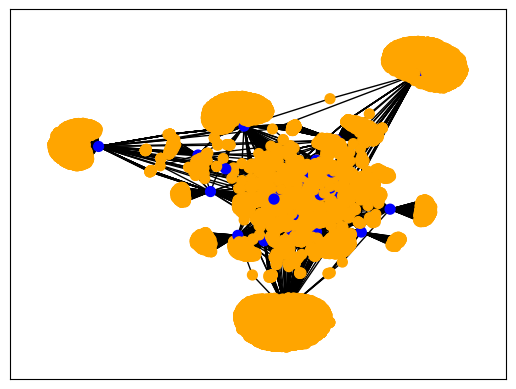

In [14]:
# draw network with colourmap according to label of node
ego_net = nx.ego_graph(G, 'PRV51001', radius=3)
node_colors = ['blue' if ego_net.nodes[n]['label'] == 'provider' else 'orange' for n in ego_net.nodes()]
nx.draw_networkx(ego_net, with_labels=False, node_size=50, font_size=5, node_color=node_colors)

## Train-test split

The train-test split can be done in many different ways. Here, we opt to apply the louvain community detection method. The resulting communities are used to split the graph into two groups, one for training and one for testing. 

We set the resolution parameter quite low to favour large communities. 

In [15]:
communities = nx.community.louvain_communities(G, resolution=0.2, seed = 2025)

In [16]:
len(communities)

6

In [17]:
for com in communities:
    print(f"Community of size: {len(com)}")

Community of size: 16002
Community of size: 12986
Community of size: 11733
Community of size: 26201
Community of size: 57136
Community of size: 19839


In [18]:
com_1 = [communities[i] for i in [1,2,4]]
com_1_nodes = [node for com in com_1 for node in com]
com_2 = [communities[i] for i in [0,3,5]]
com_2_nodes = [node for com in com_2 for node in com]

In [19]:
G_train = G.subgraph(com_1_nodes)
G_test = G.subgraph(com_2_nodes)

In [20]:
dataset_beneficiaries_train = beneficiary_features.loc[[n for n, d in G_train.nodes(data=True) if d['label'] == 'beneficiary']]
dataset_providers_train = provider_features.loc[[n for n, d in G_train.nodes(data=True) if d['label'] == 'provider']]

dataset_beneficiaries_test = beneficiary_features.loc[[n for n, d in G_test.nodes(data=True) if d['label'] == 'beneficiary']]
dataset_providers_test = provider_features.loc[[n for n, d in G_test.nodes(data=True) if d['label'] == 'provider']]

labels_providers_train = labels.loc[dataset_providers_train.index]
labels_providers_test = labels.loc[dataset_providers_test.index]

# Beneficiaries don't have labels. Make dataframes with all 0's
labels_beneficiaries_train = pd.DataFrame(0, index=dataset_beneficiaries_train.index, columns=['Label'])
labels_beneficiaries_test = pd.DataFrame(0, index=dataset_beneficiaries_test.index, columns=['Label'])

In [21]:
x_train = [
    G_train, 
    dataset_providers_train, 
    dataset_beneficiaries_train, 
    labels_providers_train,
    labels_beneficiaries_train
]

x_test = [
    G_test, 
    dataset_providers_test, 
    dataset_beneficiaries_test, 
    labels_providers_test,
    labels_beneficiaries_test
]

In [22]:
import pickle
with open('../data/HCP/hcp_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)

with open('../data/HCP/hcp_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)